# Notebook to take a first look at the HBN data and classify subjects w/ and w/out ADHD

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
from matplotlib import pyplot as plt
import nibabel as nb

import hrf_tools
from scipy.signal import resample
from scipy.stats import zscore

In [2]:
brain_dir='/nobackup/scratch/Mon/jsmentch/hbn_cifti_cleaned/smoothed/'

In [3]:
#load features from pliers
df=pd.read_csv('../sourcedata/data/HBN/features/DM_pliers_all.csv',index_col=0)

X = df.to_numpy()

X_hrf=hrf_tools.apply_optimal_hrf_10hz(X,1.25)

#resample to math TRs of 0.8 n=750 time points
X_res = []
for x in X_hrf.T:
    X_res.append(
        resample(x,750)
    )
X_res = np.array(X_res)

#zscore each feature 
X_z = zscore(X_res,axis=1)

### list all subjects to get a look at who has a dx or not

In [4]:
#load data
all_dx = np.load('../sourcedata/data/HBN/phenotype/parsed/dx_list.npy')
sub_list = np.load('../sourcedata/data/HBN/phenotype/parsed/sub_list.npy')
dx_array = np.load('../sourcedata/data/HBN/phenotype/parsed/dx_onehot.npy')

sub_list = list(sub_list)

In [5]:
subdirs=glob(f"{brain_dir}*/")
stripped = [s[:-1] for s in subdirs]
stripped = [os.path.basename(s) for s in stripped]
sub_ids = [s[4:] for s in stripped]

### how many subjects have dx data???

In [6]:
dx_count = 0
dne_count = 0
dx_array_RU = []

sub_list_w_dx = [] # ru subjects with diagnostic data available
dx_list_w_dx = [] # corresponding list of dx one hot data

for s in sub_ids:
    try:
        ind = sub_list.index(s)
        dx_count = dx_count+1
        sub_list_w_dx.append(sub_list[ind])
        dx_list_w_dx.append(dx_array[ind])
        
    except:
        #print("DNE")
        dne_count=dne_count+1
print(f"no dx data for: {dne_count}")
print(f"dx data for: {dx_count}")

no dx data for: 47
dx data for: 858


who doesn't have dx data? check it...

In [7]:
dx_df = pd.DataFrame(dx_list_w_dx)
dx_df.columns = all_dx

In [8]:
dx_sum = dx_df.sum()
print(dx_sum.to_string())

ADHD-Combined Type                                                              198.0
ADHD-Hyperactive/Impulsive Type                                                  28.0
ADHD-Inattentive Type                                                           242.0
Acute Stress Disorder                                                             0.0
Adjustment Disorders                                                             18.0
Agoraphobia                                                                       2.0
Alcohol Use Disorder                                                              1.0
Anorexia Nervosa-Binge Eating/Purging Type                                        1.0
Anorexia Nervosa-Restricting Type                                                 0.0
Autism Spectrum Disorder                                                        122.0
Avoidant/Restrictive Food Intake Disorder                                         1.0
Binge-Eating Disorder                                 

### get subjects with no dx and subjects with ASD since it is about balanced

In [9]:
asd_sub_list = [] # list of RU subject ids w asd
asd_dx_list = []  # list of RU subjects w asd full dx
nt_sub_list = []  # list of RU subjects w no dx

adhd_c_sub_list = []
adhd_c_dx_list = []

for i,s in enumerate(dx_list_w_dx):
    if s[50]==1:
        #print("NT")
        nt_sub_list.append(sub_list_w_dx[i])
    if s[9]==1:
        #print("ASD")
        asd_sub_list.append(sub_list_w_dx[i])
        asd_dx_list.append(dx_list_w_dx[i])
    if s[0]==1:
        #print("ADHD_C")
        adhd_c_sub_list.append(sub_list_w_dx[i])
        adhd_c_dx_list.append(dx_list_w_dx[i])
    

### load asd subjects. load nt subjects

In [10]:
import os.path
prefix='/nobackup/scratch/Mon/jsmentch/hbn_cifti_cleaned/smoothed/sub-'

for s in [asd_sub_list, nt_sub_list, adhd_c_sub_list]:
    total_count=0
    DM_count=0
    TP_count=0
    for a in s:
        total_count = total_count+1
        if os.path.isfile(f'{prefix}{a}/sub-{a}_clean_task-movieDM_space-fsLR_den-91k_bold.dtseries.nii'):
            DM_count =DM_count+1
        if os.path.isfile(f'{prefix}{a}/sub-{a}_clean_task-movieTP_space-fsLR_den-91k_bold.dtseries.nii'):
            TP_count =TP_count+1
    print(f'total={total_count}, the present={TP_count}, despicable me={DM_count}')

total=122, the present=114, despicable me=93
total=80, the present=74, despicable me=74
total=198, the present=184, despicable me=152


In [11]:
#build a classifier
#train on despicable me, #test on the present
#subjects who have only seen one or the other should be used for one or the other specifically

In [12]:
#load ASD despicable me
dm_asd = []

prefix='/nobackup/scratch/Mon/jsmentch/hbn_cifti_cleaned/smoothed/parcellated/sub-'

for s in asd_sub_list:
    im_file=f'{prefix}{s}/sub-{s}_clean_task-movieDM_space-fsLR_den-91k_bold.dtseries.nii'
    if os.path.isfile(im_file):
        img = nb.load(im_file)
        img_x = img.get_fdata()
        dm_asd.append(np.hstack( (img_x,X_z.T) ))

dm_asd_array = np.array(dm_asd)
#dm_asd_array =np.stack(dm_asd,axis=1)

dm_asd_stacked = np.vstack(dm_asd)

# dm_asd_array_flat = np.reshape(dm_asd_array,(len(dm_asd),270000))
# dm_asd_array_flat = np.nan_to_num(dm_asd_array_flat)

In [13]:
#load NT despicable me
dm_nt = []

prefix='/nobackup/scratch/Mon/jsmentch/hbn_cifti_cleaned/smoothed/parcellated/sub-'

for s in nt_sub_list:
    im_file=f'{prefix}{s}/sub-{s}_clean_task-movieDM_space-fsLR_den-91k_bold.dtseries.nii'
    if os.path.isfile(im_file):
        img = nb.load(im_file)
        img_x = img.get_fdata()
        dm_nt.append(np.hstack( (img_x,X_z.T) ))

dm_nt_array = np.array(dm_nt)
#dm_nt_array =np.stack(dm_nt,axis=1)
dm_nt_stacked = np.vstack(dm_nt)

# dm_nt_array_flat = np.reshape(dm_nt_array,(len(dm_nt),270000))
# dm_nt_array_flat = np.nan_to_num(dm_nt_array_flat)

In [14]:
adhd_c_sub_list

#load NT despicable me
#load ASD despicable me
dm_adhd_c = []

prefix='/nobackup/scratch/Mon/jsmentch/hbn_cifti_cleaned/smoothed/parcellated/sub-'

for s in adhd_c_sub_list:
    im_file=f'{prefix}{s}/sub-{s}_clean_task-movieDM_space-fsLR_den-91k_bold.dtseries.nii'
    if os.path.isfile(im_file):
        img = nb.load(im_file)
        img_x = img.get_fdata()
        
        dm_adhd_c.append(np.hstack( (img_x,X_z.T) ))

dm_adhd_c_array = np.array(dm_adhd_c)
#dm_adhd_c_array =np.stack(dm_adhd_c,axis=1)

dm_adhd_c_stacked = np.vstack(dm_adhd_c)

# dm_adhd_c_array_flat = np.reshape(dm_adhd_c_array,(len(dm_adhd_c),270000))
# dm_adhd_c_array_flat = np.nan_to_num(dm_adhd_c_array_flat)

## data augmentation - sliding window for training set

In [22]:
def extract_windows(array):
#     array = dm_nt_array_train[0]
#     array = np.reshape(np.arange(750),(750,1))
    examples = []
#     step_size = 10
#     window_size = 250
    step_size = 100
    window_size = 250
    steps = int((750 - window_size - step_size)/step_size) +2
    start = 0

    for i in range(steps):
        begin=start+ (i*step_size)
        example = array[begin:begin+window_size]
        examples.append(np.expand_dims(example, 0))

    return np.vstack(examples)

In [25]:
def stack_extracted(array):
    list_in = []
    for d in array:
        list_in.append(np.reshape(extract_windows(d), (-1,575) ) )
    list_in = np.stack(list_in)
    list_in=list_in.reshape(list_in.shape[0]*list_in.shape[1],list_in.shape[2])
    return list_in

In [26]:
train_nt = stack_extracted(dm_nt_array[:50])
train_asd = stack_extracted(dm_asd_array[:50])

In [27]:
train_list = []
train_list.append(train_nt)
train_list.append(train_asd)


### now try a simple RNN

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
import pandas as pd
import nibabel as nb
import hrf_tools
#from analysis import load_data_HCP_MMP

gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [29]:
#TRAINING SET
X_train = np.vstack(train_list)
X_train.shape

Y_train = np.ones( (  int(X_train.shape[0])  ,1) )
Y_train[int(int(X_train.shape[0])/2):]=0

In [30]:
#NT=0 ASD=1
#TRAINING SET
# X_train = []
# X_train.append(np.vstack(dm_nt_array[:20]))
# X_train.append(np.vstack(dm_asd_array[:20]))
# X_train = np.vstack(X_train)

# Y_train = np.ones( (30000,1) )
# Y_train[15000:]=0

#VALIDATION SET
X_val = []
X_val.append(np.vstack(dm_nt_array[50:60]))
X_val.append(np.vstack(dm_asd_array[50:60]))
X_val = np.vstack(X_val)

Y_val = np.ones( (X_val.shape[0],1) )
Y_val[ int(X_val.shape[0]/2): ]=0

#TEST SET
X_test = []
X_test.append(np.vstack(dm_nt_array[60:]))
Y_test1 = np.zeros( (np.vstack(dm_nt_array[60:]).shape[0],1) )

X_test.append(np.vstack(dm_asd_array[60:]))
Y_test2 = np.ones( (np.vstack(dm_asd_array[60:]).shape[0],1) )


X_test = np.vstack(X_test)

Y_test=[]
Y_test.append(Y_test1)
Y_test.append(Y_test2)
Y_test=np.vstack(Y_test)



#for each class:
#train on 20
#val on 5
#test on remainder
# X_val
# X_test


In [31]:
X_train=np.nan_to_num(X_train)
X_test=np.nan_to_num(X_test)
X_val=np.nan_to_num(X_val)


In [32]:
print(f'X_train = {X_train.shape}')
print(f'Y_train = {Y_train.shape}')

print(f'X_val = {X_val.shape}')
print(f'Y_val = {Y_val.shape}')

print(f'X_test = {X_test.shape}')
print(f'Y_test = {Y_test.shape}')

X_train = (150000, 575)
Y_train = (150000, 1)
X_val = (15000, 575)
Y_val = (15000, 1)
X_test = (35250, 575)
Y_test = (35250, 1)


In [46]:
# set Batch size and dimensions
batch_size = 10
time_steps = 250
input_units = 575
input_shape = (time_steps,input_units)

In [50]:
def print_dataset(ds):
    for inputs, targets in ds:
        print("---Batch---")
        print("Feature:", inputs.numpy())
        print("Label:", targets.numpy())
        print("")

In [ ]:
print_dataset(dataset_train)

In [48]:
#https://keras.io/api/preprocessing/timeseries/
#simple:
dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(data = X_train, 
                                                     targets = Y_train, 
                                                    sequence_length=time_steps,
                                                     batch_size = batch_size, shuffle=True)
dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(data = X_val, 
                                                     targets = Y_val, 
                                                    sequence_length=time_steps,
                                                     batch_size = batch_size)

dataset_test = tf.keras.preprocessing.timeseries_dataset_from_array(data = X_val, 
                                                     targets = Y_val, 
                                                    sequence_length=time_steps,
                                                     batch_size = batch_size)


#more complicated with sliding window

# dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(data = X_train, 
#                                                      targets = Y_train, 
#                                                     sequence_length=time_steps, sequence_stride = 10,
#                                                      batch_size = batch_size, shuffle=True)

# dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(data = X_val, 
#                                                      targets = Y_val, 
#                                                     sequence_length=time_steps,
#                                                      batch_size = batch_size)

# dataset_test = tf.keras.preprocessing.timeseries_dataset_from_array(data = X_val, 
#                                                      targets = Y_val, 
#                                                     sequence_length=time_steps,
#                                                      batch_size = batch_size)

In [ ]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
#model.add(layers.Embedding(input_dim=1024, output_dim=1024))

model.add(keras.Input(shape=input_shape)) #omit beacuse of bug
#model.add(layers.Dropout(0.1))
# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(32,return_sequences=True))#,batch_input_shape=(batch_size, time_steps, input_units)))
#model.add(layers.GRU(32,return_sequences=True))#,batch_input_shape=(batch_size, time_steps, input_units)))
#model.add(layers.GRU(32,return_sequences=True))#,batch_input_shape=(batch_size, time_steps, input_units)))

#model.add(layers.LSTM(64))#,batch_input_shape=(batch_size, time_steps, input_units)))
# model.add(layers.GRU(64))#,batch_input_shape=(batch_size, time_steps, input_units)))

# model.add(layers.Dense(360,activation='relu'))
# model.add(layers.Dropout(0.1))
# model.add(layers.Dense(360,activation='relu'))
# model.add(layers.Dropout(0.1))
# model.add(layers.Dense(180,activation='relu'))
# model.add(layers.Dropout(0.1))
# model.add(layers.Dense(90,activation='relu'))
# model.add(layers.Dropout(0.1))
# model.add(layers.Dense(45,activation='relu'))
# model.add(layers.Dropout(0.1))
# model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalAveragePooling1D())

#model.add(layers.Dense(360))

#model.add(layers.AveragePooling1D(pool_size=32,strides=None,data_format='channels_last'))

#model.add(layers.UpSampling1D(size=10))
#model.add(layers.Dense(17049))
#model.add(layers.Dense(128))
model.add(layers.Dense(1,activation='sigmoid')) #1 and sigmoid because doing binary classification
#model.add(layers.Dense(360))
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_accuracy', mode = 'min', verbose = 10, restore_best_weights=True, patience=200)

model.compile(
    #loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    loss=keras.losses.BinaryCrossentropy(),
    optimizer="adadelta",
    metrics=['accuracy']
)

In [49]:
model_cb = tf.keras.callbacks.ModelCheckpoint(filepath='../outputs/GRU_32_2.pb')
history_cb = tf.keras.callbacks.CSVLogger('../outputs/GRU_32_2_log.csv', separator=",", append=True)

history = model.fit(dataset_train,epochs = 1, validation_data=dataset_val, callbacks = [es, model_cb, history_cb])

14976/14976 [==============================] - 443s 29ms/step - loss: 0.6924 - accuracy: 0.5214 - val_loss: 0.6982 - val_accuracy: 0.4434


INFO:tensorflow:Assets written to: ../outputs/GRU_32_2.pb/assets


INFO:tensorflow:Assets written to: ../outputs/GRU_32_2.pb/assets


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


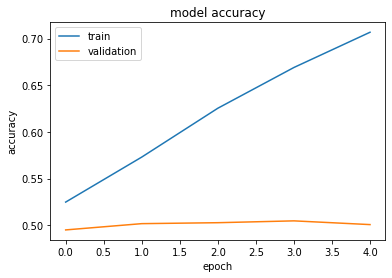

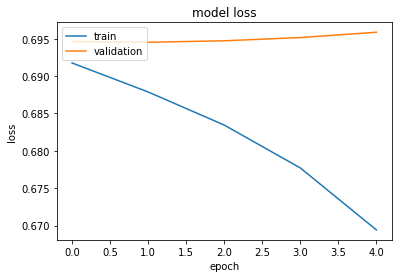

In [34]:
from matplotlib import pyplot as plt
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(dataset_test)

In [ ]:
model.save('../outputs/GRU_32_2.pb')

In [ ]:
model = keras.models.load_model('../outputs/model.pb')